In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset,random_split
# from torchvision import datasets, transforms
import pickle
import numpy as np
import joblib
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
# from imblearn.under_sampling import NearMiss
from sklearn.preprocessing import StandardScaler
# from imblearn.over_sampling import ADASYN,KMeansSMOTE,BorderlineSMOTE,SMOTE,SVMSMOTE
import sys
# from imblearn.combine import SMOTETomek
import time
from IPython.display import clear_output
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd
import json
import itertools
import ast

/data8t/haominsheng/conda/anaconda3/envs/py38new/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# 后续数据有更新，将部分文件替换为带_20240318后缀的

In [3]:
torch.cuda.is_available()

True

In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
torch.manual_seed(52)

In [4]:
# with open('./data/new_data_unlabel/new_positive_origin.pkl','rb') as f:
#     X_pos = pickle.load(f)
# X_neg=torch.load('./data/new_data_unlabel/x_unlabel.pt')

In [4]:
# X_pos.shape

In [5]:
# X_neg.shape

In [6]:
# X_all = torch.concat([X_pos,X_neg])
# X_all.shape
# Y_all = [1]*X_pos.shape[0]+[0]*X_neg.shape[0]
# Y_all = torch.tensor(Y_all)
# Y_all.shape

In [7]:
# # 计算验证集的大小（20%）
# val_size = int(len(X_all) * 0.2)
# train_size = len(X_all) - val_size
# # 生成随机索引
# indices = torch.randperm(len(X_all))
# # 划分训练集和验证集
# train_indices = indices[:train_size]
# val_indices = indices[train_size:]
# X_train = X_all[train_indices]
# Y_train = Y_all[train_indices]
# X_val = X_all[val_indices]
# Y_val = Y_all[val_indices]
# torch.save(X_train,'./11.20_data/X_train.pt')
# torch.save(Y_train,'./11.20_data/Y_train.pt')
# torch.save(X_val,'./11.20_data/X_val.pt')
# torch.save(Y_val,'./11.20_data/Y_val.pt')

In [58]:
X_train=torch.load('./11.20_data/X_train.pt')
Y_train=torch.load('./11.20_data/Y_train.pt')

In [4]:
X_val=torch.load('./11.20_data/X_val.pt')
Y_val=torch.load('./11.20_data/Y_val.pt')

In [11]:
# SMOTE
# X_train_resampled, Y_train_resampled = SMOTE().fit_resample(X_train, Y_train)
# X_train_resampled=torch.tensor(X_train_resampled)
# Y_train_resampled=torch.tensor(Y_train_resampled)
# torch.save(X_train_resampled,'./11.20_data/X_train_resampled_SMOTE.pt')
# torch.save(Y_train_resampled,'./11.20_data/Y_train_resampled_SMOTE.pt')

# scaler = StandardScaler()
# scaler.fit(np.array(X_train_resampled))
# pickle.dump(scaler, open('./11.20_model/scaler_SMOTE.pkl','wb'))

In [59]:
X_train_resampled=torch.load('./11.20_data/X_train_resampled_SMOTE.pt')
Y_train_resampled=torch.load('./11.20_data/Y_train_resampled_SMOTE.pt')

In [88]:
scaler = pickle.load(open('./11.20_model/scaler_SMOTE.pkl','rb'))

/data8t/haominsheng/conda/anaconda3/envs/py38new/lib/python3.8/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.2.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [5]:
X_train_resampled.shape

NameError: name 'X_train_resampled' is not defined

In [89]:
class CustomDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        if self.transform:
            x = self.transform(x)
        return x, y

In [90]:
torch.manual_seed(52)
# 设定超参数
input_size = 19277
hidden_size_1 = 4096
hidden_size_2 = 1024
hidden_size_3 = 256
hidden_size_4 = 64
num_classes = 1
num_epochs = 30
batch_size = 32768*1
learning_rate = 0.001

In [22]:
# train_features = []
# train_lable = []
# for inputs, _ in train_dataset:
#     train_features.append(inputs.numpy())
#     train_lable.append(_)
# train_features = np.array(train_features)

In [23]:
# val_features = []
# val_lable = []
# for inputs, _ in val_dataset:
#     val_features.append(inputs.numpy())
#     val_lable.append(_)
# val_features = np.array(val_features)

In [24]:
# scaler = StandardScaler()
# scaler.fit_transform(np.array(X_train))
# pickle.dump(scaler, open('./11.20_model/scaler.pkl','wb'))

In [73]:
train_dataset_scaled = scaler.transform(np.array(X_train_resampled))

In [8]:
val_dataset_scaled = scaler.transform(np.array(X_val))

In [74]:
train_dataset = CustomDataset(data=train_dataset_scaled,targets=Y_train_resampled,transform = None)

In [9]:
val_dataset = CustomDataset(data=val_dataset_scaled,targets=Y_val,transform = None)

In [75]:
# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [10]:
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [91]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, hidden_size_3, hidden_size_4, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size_1)
        self.bn1 = nn.BatchNorm1d(hidden_size_1)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.bn2 = nn.BatchNorm1d(hidden_size_2)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(hidden_size_2, hidden_size_3)
        self.bn3 = nn.BatchNorm1d(hidden_size_3)
        self.dropout3 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(hidden_size_3, hidden_size_4)
        self.bn4 = nn.BatchNorm1d(hidden_size_4)
        self.dropout4 = nn.Dropout(0.5)
        self.fc5 = nn.Linear(hidden_size_4, num_classes)

    def forward(self, x):
        x = self.dropout1(F.leaky_relu(self.bn1(self.fc1(x))))
        x = self.dropout2(F.leaky_relu(self.bn2(self.fc2(x))))
        x = self.dropout3(F.leaky_relu(self.bn3(self.fc3(x))))
        x = self.dropout4(F.leaky_relu(self.bn4(self.fc4(x))))
        x = self.fc5(x)
        return x

In [12]:
model = SimpleNN(input_size, hidden_size_1,hidden_size_2, hidden_size_3, hidden_size_4, num_classes)
# 损失函数和优化器
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-3)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.1)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

SimpleNN(
  (fc1): Linear(in_features=19277, out_features=4096, bias=True)
  (bn1): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=4096, out_features=1024, bias=True)
  (bn2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=1024, out_features=256, bias=True)
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (fc4): Linear(in_features=256, out_features=64, bias=True)
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout4): Dropout(p=0.5, inplace=False)
  (fc5): Linear(in_features=64, out_features=1, bias=True)
)

In [14]:
train_loss_list = []
val_loss_list = []
for epoch in range(num_epochs):
    # Training
    model.train()
    correct = 0
    total = 0
    train_loss = 0.

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images.float())
        predicted = (outputs >= 0).float()
        total += labels.size(0)
        loss = criterion(outputs, labels.view(-1,1).float())
        train_loss += loss.item()
        correct += (predicted == labels.view(-1,1)).sum().item()
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # scheduler.step()
    
    train_accuracy = 100 * correct / total
    train_loss = train_loss / len(train_loader)

    # Validation
    model.eval()
    val_labels = []
    val_predictions = []
    with torch.no_grad():
        correct = 0
        total = 0
        val_loss = 0.
        
        for i, (images, labels) in enumerate(val_loader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images.float())
            predicted = (outputs >= 0).float()
            val_labels.extend(labels.cpu().numpy())
            val_predictions.extend(predicted.cpu().numpy())
            total += labels.size(0)
            loss = criterion(outputs, labels.view(-1,1).float())
            val_loss += loss.item()
            correct += (predicted == labels.view(-1,1)).sum().item()

        val_accuracy = 100 * correct / total
        val_loss = val_loss / len(val_loader)
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    # if epoch%4 == 0:
    #     model_now = model
    #     if epoch ==0:
    #         model_final = model
    # elif val_loss<min(val_loss_list[epoch//4 *4 : epoch]):
    #     model_now = model
    #     if epoch <4:
    #         model_final = model_now
    # if epoch%4 == 3 and epoch > 3:
    #     if min(val_loss_list[epoch//4 *4 +1 : epoch]) < min(val_loss_list[: epoch//4 *4 +1])-0.05:
    #         model_final = model_now
    #     else:
    #         break
    torch.save(model.state_dict(), f'./11.20_model/SMOTE/model_epoch_{epoch+1}.pt')
    precision = precision_score(val_labels, val_predictions)
    recall = recall_score(val_labels, val_predictions)
    f1 = f1_score(val_labels, val_predictions)
    output_checkpoint=f'Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}'
    print(output_checkpoint)
    with open('./11.20_model/SMOTE/checkpoints.txt', 'a') as file:
        original_stdout = sys.stdout 
        sys.stdout = file 
        print(output_checkpoint)
        sys.stdout = original_stdout

Epoch [1/30], Train Accuracy: 66.37%, Val Accuracy: 83.93%, Train Loss: 0.6032, Val Loss: 0.4228, Precision: 0.31, Recall: 0.65, F1 Score: 0.42
Epoch [2/30], Train Accuracy: 80.20%, Val Accuracy: 78.36%, Train Loss: 0.4457, Val Loss: 0.5036, Precision: 0.27, Recall: 0.81, F1 Score: 0.40
Epoch [3/30], Train Accuracy: 84.53%, Val Accuracy: 84.91%, Train Loss: 0.3703, Val Loss: 0.3568, Precision: 0.35, Recall: 0.79, F1 Score: 0.49
Epoch [4/30], Train Accuracy: 86.46%, Val Accuracy: 90.69%, Train Loss: 0.3296, Val Loss: 0.2465, Precision: 0.49, Recall: 0.69, F1 Score: 0.57
Epoch [5/30], Train Accuracy: 89.04%, Val Accuracy: 89.79%, Train Loss: 0.2776, Val Loss: 0.2560, Precision: 0.46, Recall: 0.73, F1 Score: 0.56
Epoch [6/30], Train Accuracy: 89.28%, Val Accuracy: 85.61%, Train Loss: 0.2728, Val Loss: 0.2863, Precision: 0.35, Recall: 0.69, F1 Score: 0.47
Epoch [7/30], Train Accuracy: 90.32%, Val Accuracy: 88.69%, Train Loss: 0.2475, Val Loss: 0.2471, Precision: 0.43, Recall: 0.71, F1 Scor

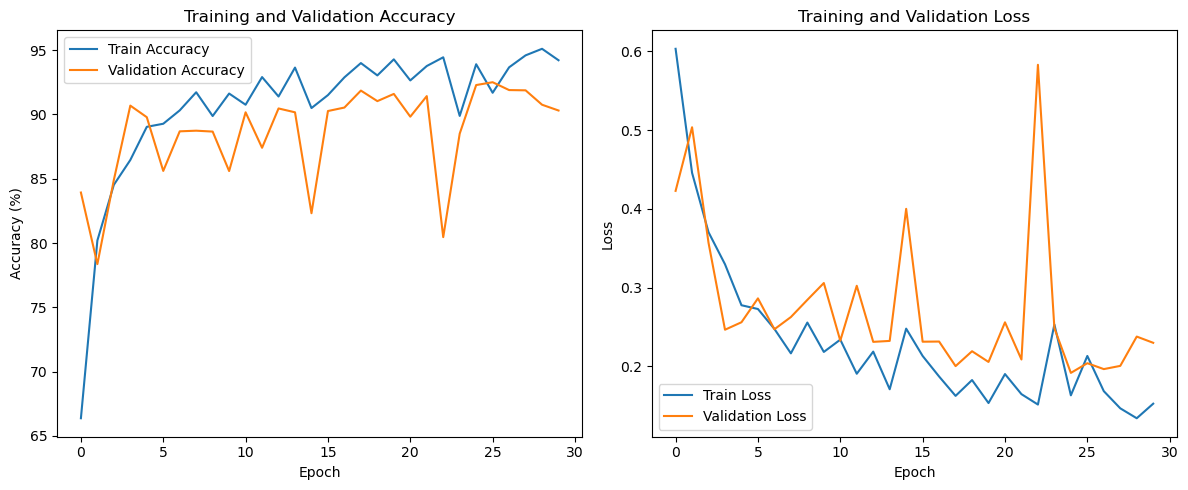

In [70]:
import matplotlib.pyplot as plt
import re

# 读取文件
with open('./11.20_model/SMOTE/checkpoints.txt', 'r') as file:
    data = file.read()

# 解析数据
pattern = r'Epoch \[\d+/\d+\], Train Accuracy: ([\d.]+)%, Val Accuracy: ([\d.]+)%, Train Loss: ([\d.]+), Val Loss: ([\d.]+), Precision: ([\d.]+), Recall: ([\d.]+), F1 Score: ([\d.]+)'
results = re.findall(pattern, data)

# 分离数据
train_accuracies = [float(result[0]) for result in results]
val_accuracies = [float(result[1]) for result in results]
train_losses = [float(result[2]) for result in results]
val_losses = [float(result[3]) for result in results]

# 绘制训练和验证准确率
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

# 绘制训练和验证损失
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


### 测试

In [12]:
model = SimpleNN(input_size, hidden_size_1,hidden_size_2, hidden_size_3, hidden_size_4, num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.load_state_dict(torch.load(f'./11.20_model/SMOTE/model_epoch_25.pt'))
# Validation
model.eval()
val_labels = []
val_predictions = []
val_outputs = []
with torch.no_grad():
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(val_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images.float())
        predicted = (outputs >= 0).float()
        val_labels.extend(labels.cpu().numpy())
        val_predictions.extend(predicted.cpu().numpy())
        val_outputs.extend(outputs)
        total += labels.size(0)
        correct += (predicted == labels.view(-1,1)).sum().item()
    val_accuracy = 100 * correct / total
precision = precision_score(val_labels, val_predictions)
recall = recall_score(val_labels, val_predictions)
f1 = f1_score(val_labels, val_predictions)
output_checkpoint=f'Val Accuracy: {val_accuracy:.4f}%, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}'
print(output_checkpoint)

Val Accuracy: 92.2920%, Precision: 0.5590, Recall: 0.7118, F1 Score: 0.6262


In [13]:
tn, fp, fn, tp = confusion_matrix(val_labels, val_predictions).ravel()
specificity = tn / (tn + fp)
print(f'specificity: {specificity:.4f}')

specificity: 0.9440


In [14]:
val_outputs=torch.stack(val_outputs).to('cuda:0')
val_probability=torch.sigmoid(val_outputs)
val_probability=val_probability.cpu().squeeze().tolist()

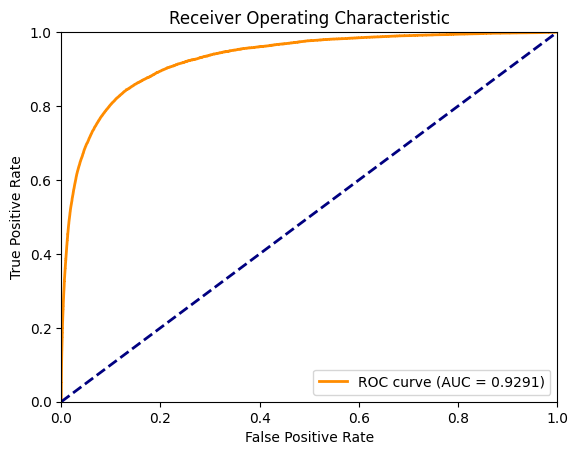

In [15]:
# ROC 曲线和 AUC
fpr, tpr, thresholds = roc_curve(val_labels, val_probability)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.ylim(0,1)
plt.xlim(0,1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

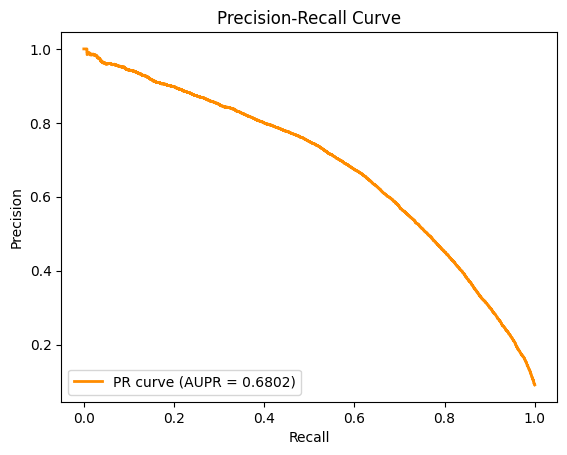

In [16]:
# PRC 曲线和 AUPR
precision, recall, thresholds = precision_recall_curve(val_labels, val_probability)
aupr = average_precision_score(val_labels, val_probability)

plt.figure()
plt.plot(recall, precision, color='darkorange', lw=2, label='PR curve (AUPR = %0.4f)' % aupr)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

### 在所有数据上进行测试

In [5]:
drugs_superstore=pd.read_csv('12.13_data/drugs_superstore.csv')[['ChemicalName','cid','smiles','drug_embedding']]
drugs_superstore['drug_embedding']=drugs_superstore['drug_embedding'].apply(json.loads) #ChemicalName、drug_embedding

In [6]:
mesh=pd.read_csv('12.13_data/mesh_info.csv')
mesh.rename(columns={'mesh':'DiseaseName'},inplace=True)
mesh['mesh_embedding']=mesh['mesh_embedding'].apply(json.loads) # DiseaseName、mesh_embedding

In [7]:
d_g=pd.read_csv('12.13_data/CTD_chemicals_diseases.csv',skiprows=range(0, 29),delimiter=',',header=None)
d_g.columns=['ChemicalName','ChemicalID','CasRN','DiseaseName','DiseaseID','DirectEvidence','InferenceGeneSymbol','InferenceScore','OmimIDs','PubMedIDs']
d_g=d_g[['ChemicalName','DiseaseID','DiseaseName','DirectEvidence']]
d_g=d_g[[True if x.split(':')[0]=='MESH' else False for x in d_g['DiseaseID']]]
d_g.loc[:,'DiseaseID']=[x.split(':')[1] for x in d_g['DiseaseID']]
d_g.dropna(subset=['DirectEvidence'],inplace=True)
# 限定d_g的疾病为mesh和ctd中都存在的
d_g=pd.merge(d_g,mesh,on='DiseaseName',how='inner')
# 限定d_g的药物为药物库里有的
d_g=pd.merge(d_g,drugs_superstore,on='ChemicalName',how='inner')
d_g=d_g.drop_duplicates(subset=['ChemicalName','DiseaseName']).reset_index(drop=True)

In [8]:
with open('12.13_data/drug_list_all.pkl', 'rb') as f:
    drug_list_all=pickle.load(f)

In [9]:
walk_results_drug = pd.read_pickle('12.13_data/walk_results_drug_7940.pkl')

In [ ]:
# 生成所有可能的配对
all_possible_pairs = pd.MultiIndex.from_product([d_g['ChemicalName'].unique(), d_g['DiseaseName'].unique()]).to_frame(index=False)
all_possible_pairs.columns = ['ChemicalName', 'DiseaseName']

In [27]:
all_possible_pairs

,ChemicalName,DiseaseName
0,"2,2',3,3',4,4',5,5',6-nonabromodiphenyl ether",Precursor Cell Lymphoblastic Leukemia-Lymphoma
1,"2,2',3,3',4,4',5,5',6-nonabromodiphenyl ether",Fetal Growth Retardation
2,"2,2',3,3',4,4',5,5',6-nonabromodiphenyl ether",Lung Neoplasms
3,"2,2',3,3',4,4',5,5',6-nonabromodiphenyl ether","Neoplasms, Experimental"
4,"2,2',3,3',4,4',5,5',6-nonabromodiphenyl ether","Leukemia, Experimental"
...,...,...
23708835,Triclabendazole,Glycogen Storage Disease Type II
23708836,Triclabendazole,Fabry Disease
23708837,Triclabendazole,Peroxisomal Disorders
23708838,Triclabendazole,Ectoparasitic Infestations


In [28]:
model = SimpleNN(input_size, hidden_size_1,hidden_size_2, hidden_size_3, hidden_size_4, num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.load_state_dict(torch.load(f'./11.20_model/SMOTE/model_epoch_25.pt'))
scaler = pickle.load(open('./11.20_model/scaler_SMOTE.pkl','rb'))

/home/zhouziyi/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.2.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [94]:
all_possible_pairs.to_csv('12.13_pred_all/all_possible_pairs.csv',index=False)

In [125]:
all_possible_pairs=pd.read_csv('12.13_pred_all/all_possible_pairs.csv')

In [126]:
all_possible_pairs

,ChemicalName,DiseaseName,output
0,"2,2',3,3',4,4',5,5',6-nonabromodiphenyl ether",Precursor Cell Lymphoblastic Leukemia-Lymphoma,NaN
1,"2,2',3,3',4,4',5,5',6-nonabromodiphenyl ether",Fetal Growth Retardation,NaN
2,"2,2',3,3',4,4',5,5',6-nonabromodiphenyl ether",Lung Neoplasms,NaN
3,"2,2',3,3',4,4',5,5',6-nonabromodiphenyl ether","Neoplasms, Experimental",NaN
4,"2,2',3,3',4,4',5,5',6-nonabromodiphenyl ether","Leukemia, Experimental",NaN
...,...,...,...
23708835,Triclabendazole,Glycogen Storage Disease Type II,NaN
23708836,Triclabendazole,Fabry Disease,NaN
23708837,Triclabendazole,Peroxisomal Disorders,NaN
23708838,Triclabendazole,Ectoparasitic Infestations,NaN


In [127]:
all_possible_pairs['output']=None

In [128]:
mesh_DiseaseName_list=mesh['DiseaseName'].tolist()

In [109]:
# s_t=time.time()
# for x in range(0,len(all_possible_pairs),14930):
#     clear_output(wait=True)
#     print(f'processing {x}/{1588}, costtime {(time.time()-s_t)/60:.2f} min, esttime {(time.time()-s_t)/60/(x/29860+0.01)*(1588-x/29860):.2f}')
#     inputs=np.zeros((14930,19277))
#     for y in range(14930):
#         disease=all_possible_pairs.loc[x+y,'DiseaseName']
#         drug=all_possible_pairs.loc[x+y,'ChemicalName']
#         disease_e=mesh.loc[mesh_DiseaseName_list.index(disease),'mesh_embedding']
#         drug_e=walk_results_drug[drug_list_all.index(drug)]['value'].tolist()
#         inputs[y,:]=np.array(drug_e+disease_e)
#         if y%1000==0:
#             print(y)
#     model.eval()
#     with torch.no_grad():
#         outputs=model(torch.tensor(scaler.transform(inputs),dtype=torch.float).to(device))
#     outputs=outputs.cpu().squeeze().tolist()
#     with open(f'12.13_pred_all/outputs/outputs_{x}.pkl','wb') as f:
#         pickle.dump(outputs,f)
#     all_possible_pairs.loc[x:(x+14930-1),'output']=outputs
# all_possible_pairs.to_csv('12.13_pred_all/all_possible_pairs_with_outputs.csv',index=False)

processing 119440/1588, costtime 2.95 min, esttime 1165.54
0
1000
2000
3000
4000


KeyboardInterrupt: 

In [129]:
s_t=time.time()
for x in range(0,529*14930,14930):
    clear_output(wait=True)
    print(f'processing {x/14930}/{529}, costtime {(time.time()-s_t)/60:.2f} min, esttime {(time.time()-s_t)/60/(x/29860+0.01)*(529-x/29860):.2f}')
    inputs=np.zeros((14930,19277))
    for y in range(14930):
        disease=all_possible_pairs.loc[x+y,'DiseaseName']
        drug=all_possible_pairs.loc[x+y,'ChemicalName']
        disease_e=mesh.loc[mesh_DiseaseName_list.index(disease),'mesh_embedding']
        drug_e=walk_results_drug[drug_list_all.index(drug)]['value'].tolist()
        inputs[y,:]=np.array(drug_e+disease_e)
        if y%1000==0:
            print(y)
    model.eval()
    with torch.no_grad():
        outputs=model(torch.tensor(scaler.transform(inputs),dtype=torch.float).to(device))
    outputs=outputs.cpu().squeeze().tolist()
    with open(f'12.13_pred_all/outputs/outputs_{x}.pkl','wb') as f:
        pickle.dump(outputs,f)
    all_possible_pairs.loc[x:(x+14930-1),'output']=outputs
all_possible_pairs.to_csv('12.13_pred_all/all_possible_pairs_with_outputs_1.csv',index=False)

processing 528.0/529, costtime 220.93 min, esttime 221.76
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000


In [21]:
s_t=time.time()
for x in range(529*14930,529*14930*2,14930):
    clear_output(wait=True)
    print(f'processing {(x-529*14930)/14930}/{529}, costtime {(time.time()-s_t)/60:.2f} min, esttime {(time.time()-s_t)/60/((x-529*14930)/29860+0.01)*(529-(x-529*14930)/29860):.2f}')
    inputs=np.zeros((14930,19277))
    for y in range(14930):
        disease=all_possible_pairs.loc[x+y,'DiseaseName']
        drug=all_possible_pairs.loc[x+y,'ChemicalName']
        disease_e=mesh.loc[mesh_DiseaseName_list.index(disease),'mesh_embedding']
        drug_e=walk_results_drug[drug_list_all.index(drug)]['value'].tolist()
        inputs[y,:]=np.array(drug_e+disease_e)
        if y%1000==0:
            print(y)
    model.eval()
    with torch.no_grad():
        outputs=model(torch.tensor(scaler.transform(inputs),dtype=torch.float).to(device))
    outputs=outputs.cpu().squeeze().tolist()
    with open(f'12.13_pred_all/outputs/outputs_{x}.pkl','wb') as f:
        pickle.dump(outputs,f)
    all_possible_pairs.loc[x:(x+14930-1),'output']=outputs
all_possible_pairs.to_csv('12.13_pred_all/all_possible_pairs_with_outputs_2.csv',index=False)

processing 528.0/529, costtime 233.65 min, esttime 234.53
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000


In [17]:
s_t=time.time()
for x in range(529*14930*2,len(all_possible_pairs),14930):
    clear_output(wait=True)
    print(f'processing {(x-529*14930*2)/14930}/{530}, costtime {(time.time()-s_t)/60:.2f} min, esttime {(time.time()-s_t)/60/((x-529*14930*2)/29860+0.01)*(530-(x-529*14930*2)/29860):.2f}')
    inputs=np.zeros((14930,19277))
    for y in range(14930):
        disease=all_possible_pairs.loc[x+y,'DiseaseName']
        drug=all_possible_pairs.loc[x+y,'ChemicalName']
        disease_e=mesh.loc[mesh_DiseaseName_list.index(disease),'mesh_embedding']
        drug_e=walk_results_drug[drug_list_all.index(drug)]['value'].tolist()
        inputs[y,:]=np.array(drug_e+disease_e)
        if y%1000==0:
            print(y)
    model.eval()
    with torch.no_grad():
        outputs=model(torch.tensor(scaler.transform(inputs),dtype=torch.float).to(device))
    outputs=outputs.cpu().squeeze().tolist()
    with open(f'12.13_pred_all/outputs/outputs_{x}.pkl','wb') as f:
        pickle.dump(outputs,f)
    all_possible_pairs.loc[x:(x+14930-1),'output']=outputs
all_possible_pairs.to_csv('12.13_pred_all/all_possible_pairs_with_outputs_3.csv',index=False)

processing 529.0/530, costtime 238.00 min, esttime 238.89
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000


### 处理所有的预测结果

In [98]:
all_possible_pairs_1=pd.read_csv('./12.13_pred_all/all_possible_pairs_with_outputs_1.csv')
all_possible_pairs_2=pd.read_csv('./12.13_pred_all/all_possible_pairs_with_outputs_2.csv')
all_possible_pairs_3=pd.read_csv('./12.13_pred_all/all_possible_pairs_with_outputs_3.csv')

In [99]:
all_possible_pairs=pd.concat([all_possible_pairs_1[0:529*14930],all_possible_pairs_2[529*14930:529*14930*2],all_possible_pairs_3[529*14930*2:]])
all_possible_pairs=all_possible_pairs.reset_index(drop=True)

In [100]:
all_possible_pairs['dataset']='test'

In [101]:
train_pairs=pd.read_csv('./12.13_pred_all/train_pairs.csv')
val_pairs=pd.read_csv('./12.13_pred_all/val_pairs.csv')

In [102]:
all_possible_pairs.loc[all_possible_pairs.set_index(['ChemicalName', 'DiseaseName']).index.isin(train_pairs.set_index(['ChemicalName', 'DiseaseName']).index),'dataset']='train'
all_possible_pairs.loc[all_possible_pairs.set_index(['ChemicalName', 'DiseaseName']).index.isin(val_pairs.set_index(['ChemicalName', 'DiseaseName']).index),'dataset']='val'

In [103]:
all_possible_pairs=all_possible_pairs.sort_values(by='output',ascending=False).reset_index(drop=True)

In [10]:
TCGA_match=pd.read_csv('TCGA_match.csv')
d_g_cancer=d_g[d_g['DiseaseName'].isin(TCGA_match['DiseaseName'])].reset_index(drop=True)
len(d_g_cancer['ChemicalName'].unique())

927

In [105]:
cancer_possible_pairs=all_possible_pairs[all_possible_pairs['DiseaseName'].isin(TCGA_match['DiseaseName'])].reset_index(drop=True)

In [106]:
cancer_possible_pairs['chemicalname']=[x.lower() for x in cancer_possible_pairs['ChemicalName']]

In [107]:
out_used_drug=pd.read_table('仅外用.txt',header=None)[0].tolist()

In [108]:
cancer_possible_pairs=cancer_possible_pairs[~cancer_possible_pairs['chemicalname'].isin(out_used_drug)].reset_index(drop=True)

In [111]:
cancer_possible_pairs.to_csv('./12.13_pred_all/cancer_possible_pairs.csv',index=False)

In [112]:
cancer_possible_pairs_top=cancer_possible_pairs[cancer_possible_pairs['output']>0]
cancer_possible_pairs_top.to_csv('./12.13_pred_all/cancer_possible_pairs_top.csv',index=False)

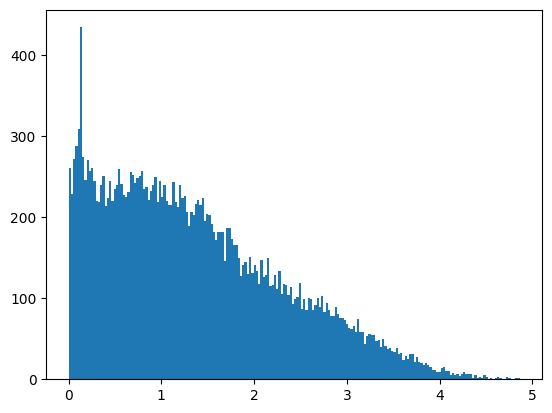

In [113]:
plt.hist(cancer_possible_pairs_top['output'],bins=200)
plt.show()

### 测试组合药物

In [11]:
walk_results_drug = pd.read_pickle('12.13_data/walk_results_drug_7940.pkl')

In [12]:
mesh=pd.read_csv('12.13_data/mesh_info.csv')
mesh.rename(columns={'mesh':'DiseaseName'},inplace=True)
mesh['mesh_embedding']=mesh['mesh_embedding'].apply(json.loads) # DiseaseName、mesh_embedding

In [13]:
with open('12.13_data/drug_list_all.pkl', 'rb') as f:
    drug_list_all=pickle.load(f)

In [14]:
cancer_possible_pairs_top=pd.read_csv('./12.13_pred_all/cancer_possible_pairs_top.csv')

In [15]:
cancer_possible_pairs_top

,ChemicalName,DiseaseName,output,dataset,chemicalname
0,Cocaine,Lung Neoplasms,4.862547,test,cocaine
1,Valproic Acid,Lung Neoplasms,4.852423,test,valproic acid
2,Phenytoin,Melanoma,4.824765,test,phenytoin
3,Methotrexate,Stomach Neoplasms,4.755996,train,methotrexate
4,Methotrexate,Melanoma,4.752745,test,methotrexate
...,...,...,...,...,...
24050,"5,5-dimethyl-1-pyrroline-1-oxide",Lung Neoplasms,0.000511,test,"5,5-dimethyl-1-pyrroline-1-oxide"
24051,Go 6976,Lung Neoplasms,0.000179,test,go 6976
24052,Norepinephrine,Pheochromocytoma,0.000087,train,norepinephrine
24053,Muscimol,Cholangiocarcinoma,0.000059,test,muscimol


In [16]:
# 选出已知有癌症疗效的药物
drug_candidate1=d_g_cancer[['ChemicalName','DiseaseName']]

In [17]:
known_drug_combination=pd.read_csv('drug_combination_cancer.csv')
known_drug_combination['drugs']=known_drug_combination['drugs'].apply(ast.literal_eval)
known_drug_list=[]
for i,row in known_drug_combination.iterrows():
    for x in row['drugs']:
        drug_candidate1.loc[len(drug_candidate1)]=[x,row['disease']]

/tmp/ipykernel_15713/1985847943.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drug_candidate1.loc[len(drug_candidate1)]=[x,row['disease']]
/tmp/ipykernel_15713/1985847943.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drug_candidate1.loc[len(drug_candidate1)]=[x,row['disease']]
/tmp/ipykernel_15713/1985847943.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drug_candidate1.loc[len(drug_candidate1)]=[x,row['disease']]
/tmp

In [18]:
drug_candidate1=drug_candidate1.drop_duplicates().reset_index(drop=True)

In [19]:
drug_candidate1['chemicalname']=[x.lower() for x in drug_candidate1['ChemicalName']]
out_used_drug=pd.read_table('仅外用.txt',header=None)[0].tolist()
drug_candidate1=drug_candidate1[~drug_candidate1['chemicalname'].isin(out_used_drug)].reset_index(drop=True)

In [20]:
drug_candidate1

,ChemicalName,DiseaseName,chemicalname
0,ABT-737,Lung Neoplasms,abt-737
1,Allopurinol,Urinary Bladder Neoplasms,allopurinol
2,Amphotericin B,Glioblastoma,amphotericin b
3,Azathioprine,Lung Neoplasms,azathioprine
4,Azathioprine,Colonic Neoplasms,azathioprine
...,...,...,...
1863,Ifosfamide,Uterine Neoplasms,ifosfamide
1864,Dacarbazine,Uterine Neoplasms,dacarbazine
1865,Cisplatin,Vulvar Neoplasms,cisplatin
1866,Paclitaxel,Vulvar Neoplasms,paclitaxel


In [21]:
chosen_pairs=cancer_possible_pairs_top[:round(len(cancer_possible_pairs_top)*0.1)]

In [22]:
chosen_pairs

,ChemicalName,DiseaseName,output,dataset,chemicalname
0,Cocaine,Lung Neoplasms,4.862547,test,cocaine
1,Valproic Acid,Lung Neoplasms,4.852423,test,valproic acid
2,Phenytoin,Melanoma,4.824765,test,phenytoin
3,Methotrexate,Stomach Neoplasms,4.755996,train,methotrexate
4,Methotrexate,Melanoma,4.752745,test,methotrexate
...,...,...,...,...,...
2401,Propafenone,Urinary Bladder Neoplasms,2.785679,test,propafenone
2402,Temozolomide,Colonic Neoplasms,2.785513,test,temozolomide
2403,Iohexol,Urinary Bladder Neoplasms,2.785187,test,iohexol
2404,Amisulpride,Melanoma,2.785132,test,amisulpride


In [23]:
chosen_pairs=chosen_pairs[['ChemicalName','DiseaseName','chemicalname']]
chosen_pairs=pd.concat([drug_candidate1,chosen_pairs]).drop_duplicates().reset_index(drop=True)

In [24]:
chosen_pairs

,ChemicalName,DiseaseName,chemicalname
0,ABT-737,Lung Neoplasms,abt-737
1,Allopurinol,Urinary Bladder Neoplasms,allopurinol
2,Amphotericin B,Glioblastoma,amphotericin b
3,Azathioprine,Lung Neoplasms,azathioprine
4,Azathioprine,Colonic Neoplasms,azathioprine
...,...,...,...
3845,GW 4064,Lung Neoplasms,gw 4064
3846,Propafenone,Urinary Bladder Neoplasms,propafenone
3847,Temozolomide,Colonic Neoplasms,temozolomide
3848,Iohexol,Urinary Bladder Neoplasms,iohexol


In [25]:
disease_list=[]
drugs_list=[]
for disease in drug_candidate1['DiseaseName'].unique():
    drugs1=drug_candidate1.loc[drug_candidate1['DiseaseName']==disease,'ChemicalName'].tolist()
    drugs2=chosen_pairs.loc[chosen_pairs['DiseaseName']==disease,'ChemicalName'].tolist()
    for x in drugs1:
        for y in drugs2:
            if x!=y:
                if x<y:
                    drugs_list.append((x,y))
                else:
                    drugs_list.append((y,x))
                disease_list.append(disease)

In [26]:
len(drugs_list)

656380

In [27]:
drug_combination=pd.DataFrame({'drugs':drugs_list,'disease':disease_list}).drop_duplicates().reset_index(drop=True)
len(drug_combination)

523063

In [28]:
known_drug_combination=pd.read_csv('drug_combination_cancer.csv')
known_drug_combination['drugs']=known_drug_combination['drugs'].apply(ast.literal_eval)
known_drug_combination=known_drug_combination[known_drug_combination['drugnumber']==2].reset_index(drop=True)
known_drug_combination=known_drug_combination[['drugs','disease']]
for x in range(len(known_drug_combination)):
    if known_drug_combination.loc[x,'drugs'][0]>known_drug_combination.loc[x,'drugs'][1]:
        known_drug_combination.loc[x,'drugs']=(known_drug_combination.loc[x,'drugs'][1],known_drug_combination.loc[x,'drugs'][0])
known_drug_combination['known']=1
known_drug_combination=known_drug_combination.drop_duplicates().reset_index(drop=True)

In [29]:
known_drug_combination

,drugs,disease,known
0,"(regorafenib, trametinib)",Adenocarcinoma,1
1,"(Fluorouracil, Leucovorin)",Adenocarcinoma,1
2,"(Capecitabine, Gemcitabine)",Adenocarcinoma,1
3,"(Cisplatin, Gemcitabine)",Adenocarcinoma,1
4,"(Fluorouracil, Mitomycin)",Anus Neoplasms,1
...,...,...,...
117,"(Doxorubicin, Trabectedin)",Uterine Neoplasms,1
118,"(Doxorubicin, Ifosfamide)",Uterine Neoplasms,1
119,"(Dacarbazine, Doxorubicin)",Uterine Neoplasms,1
120,"(Cisplatin, Paclitaxel)",Vulvar Neoplasms,1


In [30]:
drug_combination=pd.merge(drug_combination,known_drug_combination,how='left',on=['drugs','disease'])
drug_combination=drug_combination.drop_duplicates().reset_index(drop=True)
drug_combination=drug_combination.fillna(0)

In [31]:
drug_combination

,drugs,disease,known
0,"(ABT-737, Azathioprine)",Lung Neoplasms,0.0
1,"(ABT-737, Benzene)",Lung Neoplasms,0.0
2,"(ABT-737, Carboplatin)",Lung Neoplasms,0.0
3,"(ABT-737, Carmustine)",Lung Neoplasms,0.0
4,"(ABT-737, Cyclophosphamide)",Lung Neoplasms,0.0
...,...,...,...
523058,"(Dacarbazine, Trabectedin)",Uterine Neoplasms,0.0
523059,"(Dacarbazine, Ifosfamide)",Uterine Neoplasms,0.0
523060,"(Cisplatin, Paclitaxel)",Vulvar Neoplasms,1.0
523061,"(Carboplatin, Cisplatin)",Vulvar Neoplasms,0.0


In [32]:
scaler = pickle.load(open('./11.20_model/scaler_SMOTE.pkl','rb'))

/data8t/haominsheng/conda/anaconda3/envs/py38new/lib/python3.8/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.2.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [33]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, hidden_size_3, hidden_size_4, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size_1)
        self.bn1 = nn.BatchNorm1d(hidden_size_1)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.bn2 = nn.BatchNorm1d(hidden_size_2)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(hidden_size_2, hidden_size_3)
        self.bn3 = nn.BatchNorm1d(hidden_size_3)
        self.dropout3 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(hidden_size_3, hidden_size_4)
        self.bn4 = nn.BatchNorm1d(hidden_size_4)
        self.dropout4 = nn.Dropout(0.5)
        self.fc5 = nn.Linear(hidden_size_4, num_classes)

    def forward(self, x):
        x = self.dropout1(F.leaky_relu(self.bn1(self.fc1(x))))
        x = self.dropout2(F.leaky_relu(self.bn2(self.fc2(x))))
        x = self.dropout3(F.leaky_relu(self.bn3(self.fc3(x))))
        x = self.dropout4(F.leaky_relu(self.bn4(self.fc4(x))))
        x = self.fc5(x)
        return x

In [34]:
torch.manual_seed(52)
# 设定超参数
input_size = 19277  # 对于MNIST数据集
hidden_size_1 = 4096
hidden_size_2 = 1024
hidden_size_3 = 256
hidden_size_4 = 64
num_classes = 1
num_epochs = 30
batch_size = 32768*1
learning_rate = 0.001

In [35]:
torch.cuda.set_device(1)

In [36]:
model = SimpleNN(input_size, hidden_size_1,hidden_size_2, hidden_size_3, hidden_size_4, num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# model.load_state_dict(torch.load(f'./11.20_model/SMOTE/model_epoch_25.pt'))
# model.load_state_dict(torch.load(f'./11.20_model/finetune/model_epoch_10_finetune_number_70_e_5.pt'))
# finetune最好的模型
model.load_state_dict(torch.load(f'./11.20_model/finetune_new/model_finetune_225_e_16_epoch_26.pt'))

<All keys matched successfully>

In [37]:
mesh_list=mesh['DiseaseName'].tolist()

In [38]:
drug_combination['output']=0
drug_combination_data = []
for i,row in drug_combination.iterrows():
    drugs = list(row['drugs'])
    disease = row['disease']
    drug_comb_embedding =[0.]*len(walk_results_drug[0])
    for drug in drugs:
        ind = drug_list_all.index(drug)
        drug_comb_embedding = [x+y for x,y in zip(drug_comb_embedding,list(walk_results_drug[ind]['value']))]
    comb_embedding = drug_comb_embedding+mesh.loc[mesh_list.index(disease),'mesh_embedding']
    drug_combination_data.append(comb_embedding)
    if (i+1)%3000==0:
        print(f'{i+1}/{len(drug_combination)}')
        drug_combination_data=np.array(drug_combination_data)
        model.eval()
        with torch.no_grad():
            test_comb_outputs=model(torch.tensor(scaler.transform(drug_combination_data),dtype=torch.float).to(device))
        test_comb_outputs=test_comb_outputs.squeeze().cpu().tolist()
        drug_combination.loc[(i-2999):i,'output']=test_comb_outputs
        drug_combination_data = []
    if i==(len(drug_combination)-1):
        print(f'{i+1}/{len(drug_combination)}')
        drug_combination_data=np.array(drug_combination_data)
        model.eval()
        with torch.no_grad():
            test_comb_outputs=model(torch.tensor(scaler.transform(drug_combination_data),dtype=torch.float).to(device))
        test_comb_outputs=test_comb_outputs.squeeze().cpu().tolist()
        drug_combination.loc[(i-len(drug_combination_data)+1):(len(drug_combination)-1),'output']=test_comb_outputs
        drug_combination_data = []

3000/523063
6000/523063
9000/523063
12000/523063
15000/523063
18000/523063
21000/523063
24000/523063
27000/523063
30000/523063
33000/523063
36000/523063
39000/523063
42000/523063
45000/523063
48000/523063
51000/523063
54000/523063
57000/523063
60000/523063
63000/523063
66000/523063
69000/523063
72000/523063
75000/523063
78000/523063
81000/523063
84000/523063
87000/523063
90000/523063
93000/523063
96000/523063
99000/523063
102000/523063
105000/523063
108000/523063
111000/523063
114000/523063
117000/523063
120000/523063
123000/523063
126000/523063
129000/523063
132000/523063
135000/523063
138000/523063
141000/523063
144000/523063
147000/523063
150000/523063
153000/523063
156000/523063
159000/523063
162000/523063
165000/523063
168000/523063
171000/523063
174000/523063
177000/523063
180000/523063
183000/523063
186000/523063
189000/523063
192000/523063
195000/523063
198000/523063
201000/523063
204000/523063
207000/523063
210000/523063
213000/523063
216000/523063
219000/523063
222000/523063


In [39]:
drug_combination=drug_combination.sort_values(by='output',ascending=False).reset_index(drop=True)

In [41]:
drug_combination

,drugs,disease,known,output
0,"(Cytarabine, Leucovorin)",Colonic Neoplasms,0.0,7.230906
1,"(Cytarabine, Leucovorin)",Stomach Neoplasms,0.0,7.203909
2,"(Cytarabine, Leucovorin)",Lung Neoplasms,0.0,7.162966
3,"(Cytarabine, Leucovorin)","Carcinoma, Hepatocellular",0.0,7.044796
4,"(Cytarabine, Doxorubicin)",Colonic Neoplasms,0.0,6.917316
...,...,...,...,...
523058,"(2,3',4,4',5-pentachlorobiphenyl, Tetrachlorod...",Cholangiocarcinoma,0.0,-10.586791
523059,"(2,3',4,4',5-pentachlorobiphenyl, Chlorodiphen...",Cholangiocarcinoma,0.0,-11.001800
523060,"(Chlorodiphenyl (54% Chlorine), gallium nitrate)","Carcinoma, Hepatocellular",0.0,-11.655272
523061,"(2,3',4,4',5-pentachlorobiphenyl, Pentachlorop...",Cholangiocarcinoma,0.0,-11.680082


In [42]:
drug_combination.to_csv('./12.13_pred_all/drug_combination_pred_ft_0306.csv',index=False)